**Data preprocess**
1. normalize 2.zero-fill. 

3. Augment (in order): mirror-flip, spatial affine, spatial mask, # time dilate, time-shift, temporal mask

4. Resize if larger than max length. Concat with dx and dx2. 

(No frames were dropped) 

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import json
from tensorflow.keras import layers
import tensorflow.keras.mixed_precision as mixed_precision
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import gc
import random
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'

D0901 07:12:33.021384481      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0901 07:12:33.021408895      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0901 07:12:33.021412197      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0901 07:12:33.021414837      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0901 07:12:33.021417488      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0901 07:12:33.021420058      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0901 07:12:33.021422487      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0901 07:12:33.

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything()

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
    N_REPLICAS = strategy.num_replicas_in_sync
    print("REPLICAS: ", N_REPLICAS)
    
except:
    strategy = tf.distribute.get_strategy()
    N_REPLICAS = 1

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [3]:
data_subset = 100 if IS_INTERACTIVE else None # Size of subset of data to use, for faster debugging. Set None for all data.
val_fold = 0 # Choose from 0th-5th fold as the validation
model_output_name = 'modelv9'  #Specify the name of the output model

# parameters of model architecture
num_heads = 2      # Number of attention heads
head_size = 128    # Dimension of each head
kernel_size = 4   # Kernel size of local attention
DIM = num_heads*head_size  # This will be the dimension of the embedding and attention
CNN_ksize = int(np.sqrt(DIM))
dropout = 0.33 
num_enc_layers = 6    # Number of attention blocks for input and output 
num_dec_layers = 4
# Parameters for training
epochs = 3 if IS_INTERACTIVE else 300
lr = 3e-4*N_REPLICAS
lr_min = 1e-6 # minimum learning rate over time
warmup_epochs = 0 if IS_INTERACTIVE else 5
resume_epoch = 0 # Suppose we want to resume training
decay_epochs = 200 #scale at which the lr decays. 
decay_type = 'exponential'
awp_start_epoch = 20
batch_size = 32*N_REPLICAS
early_stop_patience = 10  # If the validation error doesn't improve in this many epochs, stop early
#dropout_start_epoch = 10
#Parameters of data preprocessing and augmentation
# Set to none for no augmentation
rot_deg = (-20., 20.) 
shift = (-0.1, 0.1)
scale = (0.8, 1.2)
shear = (-0.2, 0.2)
time_dilation = (0.7, 1.3)
time_mask_prob = 0.03
spatial_mask_size = 0.3
max_time_offset = 50


# Parameters of structure of data
NUM_POINTS = 42
CHANNELS = NUM_POINTS*6
MAX_INPUT_LEN = 512 #Because we drop nan frames
MAX_OUTPUT_LEN = 31+2 #+2 for the start and end token 

f = open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json')
char2id = json.load(f)
f.close()
start_token = '\t'
start_token_idx = 59
end_token = '\n'
end_token_idx = 60
pad_token = 'P'
TKPAD = 61 
char2id[start_token] = start_token_idx   #Use as start token
char2id[end_token]= end_token_idx   #Use as end token
char2id[pad_token] = TKPAD
id2char = {char2id[c]:c for c in char2id.keys()}
VOCAB_SIZE = len(char2id) #includes start, end, pad tokens.
LMPAD = -100.0

verbose = 1 if IS_INTERACTIVE else 2 

In [4]:
train_files = [f'/kaggle/input/aslfstfrecords3/fold{i}.tfrecords' for i in range(6)]
val_files = train_files[val_fold]
del train_files[val_fold]

num_samples_per_file = [11155, 11230, 11141, 11237, 11267, 11178]
total_num_samples = sum(num_samples_per_file)
val_num_samples = num_samples_per_file[val_fold]
train_num_samples = total_num_samples - val_num_samples
steps_per_epoch = int(np.ceil(train_num_samples/batch_size))
val_steps = int(np.ceil(val_num_samples/batch_size))

AUTO = tf.data.AUTOTUNE

#decode single record
def decode_record(record_bytes):
    features = tf.io.parse_single_example(record_bytes,{
                                          'right_hand':tf.io.FixedLenFeature([],tf.string),
                                          'left_hand':tf.io.FixedLenFeature([],tf.string),
                                          'left_pose':tf.io.FixedLenFeature([],tf.string),
                                          'right_pose':tf.io.FixedLenFeature([],tf.string),
                                          'lip':tf.io.FixedLenFeature([],tf.string),
                                          'encoded_phrase':tf.io.VarLenFeature(tf.int64),
                                        })
    features['encoded_phrase'] = tf.cast(tf.sparse.to_dense(features['encoded_phrase']),tf.int32)
    features['right_hand'] = tf.reshape(tf.io.decode_raw(features['right_hand'], tf.float32), (-1,21,3))
    features['left_hand'] = tf.reshape(tf.io.decode_raw(features['left_hand'], tf.float32), (-1,21,3))
    #features['left_pose'] = tf.reshape(tf.io.decode_raw(features['left_pose'], tf.float32), (-1,6,3))
    #features['right_pose'] = tf.reshape(tf.io.decode_raw(features['right_pose'], tf.float32), (-1,6,3))
    #features['lip'] = tf.reshape(tf.io.decode_raw(features['lip'], tf.float32), (-1,40,3))
    
    return tf.concat([features['right_hand'][:,:,:2], features['left_hand'][:,:,:2]],axis=1), features['encoded_phrase']

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

def normalize_fillna(coord, text):
    coord = coord-tf_nan_mean(coord, axis=(0,1))
    coord = coord/tf_nan_std(coord,axis=(0,1,2))
    coord = tf.where(tf.math.is_nan(coord), 0., coord)
    return coord, text
  
# Some augmentation functions.
def spatial_affine(coord, scale = scale, shear = shear,
                   shift = shift, degree = rot_deg):
    if scale:
        coord *= tf.random.uniform((),*scale)
        
    if shear:
        if tf.random.uniform(())<0.5:
            shear_x = 0.
            shear_y = tf.random.uniform((),*shear)
        else:
            shear_y = 0.
            shear_x = tf.random.uniform((),*shear)
        shear_mat = tf.identity([[1., shear_x],
                                 [shear_y, 1.]])
        coord = coord @ shear_mat
        
    if degree:
        rad = tf.random.uniform((),*degree)*np.pi/180
        c = tf.math.cos(rad)
        s = tf.math.sin(rad)
        rot_mat = tf.identity([[c, s],
                               [-s, c]])
        coord = coord@rot_mat
    if shift:
        coord += tf.random.uniform((2,),*shift)[None,None,:]
    return coord

def time_dilate(coord, dilate_range=time_dilation):
    T = tf.shape(coord)[0]
    P = tf.shape(coord)[1]
    rate = tf.random.uniform((),*dilate_range)
    T_target = tf.cast(rate * tf.cast(T,tf.float32), tf.int32)
    T_target = tf.math.maximum(T_target, 1)
    coord = tf.image.resize(coord, (T_target, P))
    return coord

def temporal_mask(coord, rate=time_mask_prob, mask_value = 0.):
    T = tf.shape(coord)[0]
    mask = tf.random.uniform((T,))<rate
    coord = tf.where(mask[:,None,None], mask_value, coord)
    return coord

def time_shift(coord, max_shift=max_time_offset, mask_value=0.):
    P = tf.shape(coord)[1]
    shift = tf.random.uniform((),0,max_shift,dtype=tf.int32)
    coord = tf.concat([tf.zeros((shift,P,2)),coord], axis = 0)
    return coord

def spatial_mask(coord, size=spatial_mask_size, mask_value=0.):
    half = size/2
    x_center = tf.random.uniform((), -3, 3)
    y_center = tf.random.uniform((), -3, 3)
    mask = (x_center-half<coord[:,:,0]) & (coord[:,:,0]<x_center+half) \
            & (y_center-half<coord[:,:,0]) & (coord[:,:,0]<y_center+half)
    coord = tf.where(mask[:,:,None], mask_value, coord)
    return coord
    
def flip_rl(coord):
    right = coord[:,:21,:]
    left = coord[:,21:,:]
    axis_to_flip = tf.constant([True,False])[None,None,:]
    right = tf.where(axis_to_flip,-right,right)
    left = tf.where(axis_to_flip,-left,left)
    return tf.concat([left,right],axis=1) #Fix bug

def augment_fn(coord,text,always=False):
    
    if tf.random.uniform(())<0.5:
        coord = flip_rl(coord)
        
    if always or tf.random.uniform(())<0.8:
        coord = spatial_affine(coord)
        
    if always or tf.random.uniform(())<0.25:
        coord = spatial_mask(coord)
    
    if always or tf.random.uniform(())<0.8:
        coord = time_dilate(coord)
    
    if always or tf.random.uniform(())<0.3:
        coord = time_shift(coord)
        
    if always or tf.random.uniform(())<0.5:
        coord = temporal_mask(coord)
    
    return coord,text

def resize(coord):
    T = tf.shape(coord)[0]
    P = tf.shape(coord)[1]
    if T>MAX_INPUT_LEN:
        coord = tf.image.resize(coord,(MAX_INPUT_LEN, P))
    return coord

def format_sample(coord,text):
    coord = resize(coord)
    
    num_points = tf.shape(coord)[1]
    coord = tf.reshape(coord,(-1,2*num_points))
    
    dx = tf.cond(tf.shape(coord)[0]>1,
                 lambda:tf.pad(coord[1:,:] - coord[:-1,:], [[0,1],[0,0]]),
                 lambda:tf.zeros_like(coord))   
    dx2 = tf.cond(tf.shape(coord)[0]>2,
             lambda:tf.pad(coord[2:,:] - coord[:-2,:], [[0,2],[0,0]]),
             lambda:tf.zeros_like(coord))

    coord = tf.concat([coord,dx,dx2],axis=1)
    
    #coord = tf.boolean_mask(coord, ~tf.reduce_all(tf.math.is_nan(coord),axis=1)) #Drop if it's all nan. 
    #coord = tf.where(tf.reduce_all(tf.math.is_nan(coord),axis=1,keepdims=True), LMPAD, coord)
    #coord = tf.where(tf.math.is_nan(coord), 0., coord)
    
    text = tf.concat([tf.constant([start_token_idx]), text, tf.constant([end_token_idx])],axis=0)
    
    return coord,text

def context_target_split(coord,text):
    return (coord,text[:,:-1]), text[:,1:]


def preprocess(ds, augment=False,repeat=False,shuffle=False):
    ds = ds.map(decode_record, AUTO) #returns (lm of right and left frame, encoded_phrase), where lm are in shape (frames, points, xy)
    ds = ds.map(normalize_fillna, AUTO)
    if augment:
        ds = ds.map(augment_fn, AUTO)
        
    ds = ds.map(format_sample, AUTO) 
    
    if repeat:
        ds = ds.repeat()
    if shuffle:
        ds = ds.shuffle(8191)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)
        
    ds = ds.padded_batch(batch_size, 
                         padding_values = (LMPAD,TKPAD), 
                         padded_shapes = ([MAX_INPUT_LEN,6*NUM_POINTS],[MAX_OUTPUT_LEN]))
    
    ds = ds.map(context_target_split, AUTO)
    ds = ds.prefetch(AUTO)
    return ds
   
train_ds = tf.data.TFRecordDataset(train_files, num_parallel_reads=AUTO,
                                    compression_type='GZIP')
val_ds = tf.data.TFRecordDataset(val_files, num_parallel_reads=AUTO,
                                    compression_type='GZIP')

if data_subset:
    train_ds = train_ds.take(data_subset)
    val_ds = val_ds.take(data_subset//5)
    
train_ds = preprocess(train_ds, augment=True, repeat=True, shuffle=True)
val_ds = preprocess(val_ds)

In [5]:
if IS_INTERACTIVE:
    steps_per_epoch = np.ceil(data_subset/batch_size)
    val_steps = np.ceil((data_subset//5)/batch_size)

In [6]:
for s in train_ds:
    (coord, context), label = s
    print('inpu coordinate shape',coord.shape)
    print('input context shape', context.shape)
    print('label shape', label.shape)
    print('2 Samples of context:')
    print(context[:2])
    print('2 Samples of label:')
    print(label[:2])
    break

inpu coordinate shape (256, 512, 252)
input context shape (256, 32)
label shape (256, 32)
2 Samples of context:
tf.Tensor(
[[59 20 24 16 15  0 36 32 50 51  0 33 32 56 53 40 36 54  0 34 46 52 49 51
  60 61 61 61 61 61 61 61]
 [59 41 44 43 32 45 35 46 45 54 49 40 51 40 45 38 13 34 46 44 14 60 61 61
  61 61 61 61 61 61 61 61]], shape=(2, 32), dtype=int32)
2 Samples of label:
tf.Tensor(
[[20 24 16 15  0 36 32 50 51  0 33 32 56 53 40 36 54  0 34 46 52 49 51 60
  61 61 61 61 61 61 61 61]
 [41 44 43 32 45 35 46 45 54 49 40 51 40 45 38 13 34 46 44 14 60 61 61 61
  61 61 61 61 61 61 61 61]], shape=(2, 32), dtype=int32)


In [7]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=CNN_ksize,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

class Conv1DBlock(layers.Layer):
    def __init__(self,channel_size=DIM,kernel_size=CNN_ksize, dilation_rate=1, drop_rate=dropout,
          expand_ratio=2, se_ratio=0.25, activation='swish', **kwargs):
        super().__init__(**kwargs)
        self.expand = layers.Dense(channel_size*expand_ratio)
        self.dwconv = CausalDWConv1D(kernel_size,dilation_rate=dilation_rate,use_bias=False)
        self.bn = layers.BatchNormalization(momentum=0.95)
        self.eca = ECA()
        self.proj = layers.Dense(channel_size,use_bias=True)
        self.drop = layers.Dropout(drop_rate, noise_shape=(None,1,1))
        self.add = layers.Add()
        self.supports_masking=True
    '''
    efficient conv1d block, @hoyso48
    '''
    # Expansion phase
    def call(self, x):
        bypass = x
        x = self.expand(x)
        # Depthwise Convolution
        x = self.dwconv(x)
        x = self.bn(x)
        x = self.eca(x)
        x = self.proj(x)
        x = self.drop(x)
        x = self.add([x,bypass])
        return x   

class TokenEmbedding(layers.Layer):
    """Input: (*, seq_len). Output: (*, seq_len, embedding_dim)
    Input 0 will be masked.
    CHECK: Can we speed up by making pos a constant tensor?"""
    
    def __init__(self, vocab_size=VOCAB_SIZE, max_len=MAX_OUTPUT_LEN, embed_dim=DIM, 
                 pad_value=TKPAD, dropout=dropout, **kwargs):
        super().__init__(**kwargs)
        self.tok_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(max_len, embed_dim)
        self.drop = layers.Dropout(dropout)
        self.pad = pad_value
        self.scale = tf.math.sqrt(tf.cast(embed_dim,tf.float32))
        self.pos = tf.range(max_len)[None,:]
        self.ln = layers.LayerNormalization(center=False)
        
    def call(self, x):
        #B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        x = self.tok_emb(x)
        x *= self.scale # Set the relative scale of the token and position embeddng
        pos = self.pos_emb(self.pos[:,:T])
        x = x+pos
        x = self.drop(x)
        x = self.ln(x)
        return x
    
    def compute_mask(self,x, mask=None):
        new_mask = x!=self.pad
        if mask:
            new_mask = new_mask & mask
        return new_mask
    

class CoordEmbedding(layers.Layer):
    """Input: (*, seq_len, channels). Output: (*, seq_len, embedding_dim)
    Also creates mask for any time frame that includes mask_value"""
    
    def __init__(self, max_len=MAX_INPUT_LEN, embed_dim=DIM, dropout=dropout, mask_value=LMPAD, **kwargs):
        super().__init__(**kwargs)
        
        self.masking = layers.Masking(mask_value=mask_value)
        self.emb = layers.Dense(embed_dim) #bias or not is debatable
        self.bn = layers.BatchNormalization(momentum=0.95)
        self.convs = [Conv1DBlock(embed_dim,kernel_size=CNN_ksize,drop_rate=dropout) for _ in range(3)]
        
        self.pos_emb = layers.Embedding(max_len, embed_dim)
        self.drop = layers.Dropout(dropout)
        self.scale = tf.math.sqrt(tf.cast(embed_dim,tf.float32))
        self.pad = mask_value
        self.pos = tf.range(max_len)[None,:]
        self.ln = layers.LayerNormalization(center=False)
        
    def call(self, x):
        #B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        x = self.masking(x)
        x = self.emb(x)
        x = self.bn(x)
        
        for conv in self.convs:
            x = conv(x)
        
        x *= self.scale  # Set the relative scale of the token and position embeddng
        pos = self.pos_emb(self.pos[:,:T])
        x = x + pos
        x = self.drop(x)
        x = self.ln(x)
        return x
    
    def compute_mask(self, x, mask=None):
        new_mask = tf.reduce_all(x!=self.pad, axis=-1)
        if mask:
            new_mask = new_mask & mask
        return new_mask
    
class MLP(layers.Layer):
    """input and output are the same shape. 
    Dense layer to 4x the hidden dim and then dense layer back to 1x hidden dim"""
    def __init__(self, input_dim=DIM, dropout=dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.c_fc = layers.Dense(4*input_dim, use_bias=bias, activation='gelu')
        self.c_proj = layers.Dense(input_dim, use_bias=bias)
        self.drop = layers.Dropout(dropout) # CHECK noise_shape later
        self.supports_masking=True
        
    def call(self, x):
        x = self.c_fc(x)
        x = self.c_proj(x)
        x = self.drop(x)
        return x

class EncoderTransformerBlock(layers.Layer):
    def __init__(self,head_size=head_size, num_heads=num_heads, dropout=dropout, kernel_size=kernel_size, num_local=2, **kwargs):
        super().__init__(**kwargs)
        self.num_local = num_local
        self.lns = [layers.LayerNormalization(center=False) for _ in range(self.num_local)]
        self.adds = [layers.Add() for _ in range(self.num_local)]
        self.local_atts = [layers.MultiHeadAttention(num_heads,head_size,dropout=dropout,use_bias=False) for _ in range(self.num_local)]
        self.local_mask = tf.cast(tf.linalg.band_part(
                        tf.ones((MAX_INPUT_LEN,MAX_INPUT_LEN)), kernel_size-1, 0), tf.bool)
        
        self.ln2 = layers.LayerNormalization(center=False)
        self.add2 = layers.Add()
        self.global_att = layers.MultiHeadAttention(num_heads,head_size,dropout=dropout,use_bias=False)
        
        self.ln3 = layers.LayerNormalization(center=False)
        self.mlp = MLP(head_size*num_heads)
        self.add3 = layers.Add()
        
        self.support_masking=True   
    
    def call(self,x):
        T = tf.shape(x)[1]
        for i in range(self.num_local):
            bypass = x
            x = self.lns[i](x)
            x = self.local_atts[i](x,x, attention_mask = self.local_mask[:T,:T])
            x = self.adds[i]([x,bypass])
        
        bypass = x
        x = self.ln2(x)
        x = self.global_att(x,x)
        x = self.add3([x,bypass])                
        
        bypass = x
        x = self.ln3(x)
        x = self.mlp(x)
        x = self.add3([x,bypass])
        
        return x


class DecoderTransformerBlock(layers.Layer):
    """"""
    def __init__(self,head_size=head_size, num_heads=num_heads, dropout=dropout, **kwargs):
        super().__init__(**kwargs)
        self.support_masking=True
        self.ln1 = layers.LayerNormalization(center=False)
        self.ln2 = layers.LayerNormalization(center=False)
        self.ln3 = layers.LayerNormalization(center=False)
        self.self_att = layers.MultiHeadAttention(num_heads,head_size,dropout=dropout,use_bias=False)
        self.cross_att = layers.MultiHeadAttention(num_heads,head_size,dropout=dropout,use_bias=False)
        self.mlp = MLP(head_size*num_heads)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        self.add3 = layers.Add()
        
    def call(self, x, y):
        # x is the source sequence (landmarks), y is the target seuqence (phrase)
        bypass = y
        y = self.ln1(y)
        y = self.self_att(y,y,use_causal_mask=True) # Check that self att works out with the double masks
        y = self.add1([y,bypass])
              
        bypass = y 
        y = self.ln2(y)
        y = self.cross_att(y,x) # Check that cross att works out with the mask of x.
        y = self.add2([y, bypass])
        
        bypass= y 
        y = self.ln3(y)
        y = self.mlp(y)
        y = self.add3([y,bypass])
        
        return y


In [8]:
class OneCycleLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Unified single-cycle learning rate scheduler for tensorflow.
    2022 Hoyeol Sohn <hoeyol0730@gmail.com>"""
    def __init__(self, lr=1e-4, epochs=10, steps_per_epoch=100, steps_per_update=1,
                resume_epoch=0, decay_epochs=10, sustain_epochs=0, warmup_epochs=0,
                lr_start=0, lr_min=0, warmup_type='linear', decay_type='cosine', **kwargs):
        
        super().__init__(**kwargs)
        self.lr = float(lr)
        self.epochs = float(epochs)
        self.steps_per_update = float(steps_per_update)
        self.resume_step = float(resume_epoch*steps_per_epoch)
        self.steps_per_epoch = float(steps_per_epoch)
        self.decay_steps = float(decay_epochs*steps_per_epoch)
        self.sustain_steps = float(sustain_epochs*steps_per_epoch)
        self.warmup_steps = float(warmup_epochs*steps_per_epoch)
        self.total_steps = float(epochs*steps_per_epoch)
        self.lr_start = float(lr_start)
        self.lr_min = float(lr_min)
        self.decay_type = decay_type
        self.warmup_type = warmup_type
        
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        if self.resume_step:
            step = step + self.resume_step

        step = tf.cond(step > self.decay_steps, lambda :self.decay_steps, lambda :step)
        step = tf.math.truediv(step, self.steps_per_update) * self.steps_per_update

        warmup_cond = step < self.warmup_steps
        decay_cond = step >= (self.warmup_steps + self.sustain_steps)
        
        if self.warmup_type == 'linear':
            lr = tf.cond(warmup_cond, lambda: tf.math.divide_no_nan(self.lr-self.lr_start , self.warmup_steps) * step + self.lr_start, lambda: self.lr)
        elif self.warmup_type == 'exponential':
            factor = tf.pow(self.lr_start, 1/self.warmup_steps)
            lr = tf.cond(warmup_cond, lambda: (self.lr - self.lr_start) * factor**(self.warmup_steps - step) + self.lr_start, lambda: self.lr)
        elif self.warmup_type == 'cosine':
            lr = tf.cond(warmup_cond, lambda: 0.5 * (self.lr - self.lr_start) * (1 + tf.cos(3.14159265359 * (self.warmup_steps - step)  / self.warmup_steps)) + self.lr_start, lambda:self.lr)
        else:
            raise NotImplementedError
                    
        if self.decay_type == 'linear':
            lr = tf.cond(decay_cond, lambda: self.lr + (self.lr_min-self.lr)/(self.decay_steps - self.warmup_steps - self.sustain_steps)*(step - self.warmup_steps - self.sustain_steps), lambda:lr)
        elif self.decay_type == 'exponential':
            factor = tf.pow(self.lr_min, 1/(self.decay_steps - self.warmup_steps - self.sustain_steps))
            lr = tf.cond(decay_cond, lambda: (self.lr - self.lr_min) * factor**(step - self.warmup_steps - self.sustain_steps) + self.lr_min, lambda:lr)
        elif self.decay_type == 'cosine':
            lr = tf.cond(decay_cond, lambda: 0.5 * (self.lr - self.lr_min) * (1 + tf.cos(3.14159265359 * (step - self.warmup_steps - self.sustain_steps) / (self.decay_steps - self.warmup_steps - self.sustain_steps))) + self.lr_min, lambda:lr)
        else:
            raise NotImplementedError
        return lr

    def plot(self):
        step = max(1, int(self.total_steps)//1000) #1 for total_steps < 1000, total_steps//1000 else
        eps = list(range(0,int(self.total_steps),step))
        learning_rates = [self(x) for x in eps]
        eps = [x/self.steps_per_epoch for x in eps]
        plt.scatter(eps,learning_rates,2)
        plt.title('Learning rate schedule')
        plt.xlabel('epochs')
        plt.ylabel('learning rate')
        plt.show()    

class AWP(tf.keras.Model):
    """2022 Hoyeol Sohn <hoeyol0730@gmail.com>"""
    def __init__(self, *args, delta=0.1, eps=1e-4, start_step=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.delta = delta
        self.eps = eps
        self.start_step = start_step
        
    def train_step_awp(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        params = self.trainable_variables
        params_gradients = tape.gradient(loss, self.trainable_variables)
        for i in range(len(params_gradients)):
            grad = tf.zeros_like(params[i]) + params_gradients[i]
            delta = tf.math.divide_no_nan(self.delta * grad , tf.math.sqrt(tf.reduce_sum(grad**2)) + self.eps)
            self.trainable_variables[i].assign_add(delta)
        with tf.GradientTape() as tape2:
            y_pred = self(x, training=True)
            new_loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            if hasattr(self.optimizer, 'get_scaled_loss'):
                new_loss = self.optimizer.get_scaled_loss(new_loss)
            
        gradients = tape2.gradient(new_loss, self.trainable_variables)
        if hasattr(self.optimizer, 'get_unscaled_gradients'):
            gradients =  self.optimizer.get_unscaled_gradients(gradients)
        for i in range(len(params_gradients)):
            grad = tf.zeros_like(params[i]) + params_gradients[i]
            delta = tf.math.divide_no_nan(self.delta * grad , tf.math.sqrt(tf.reduce_sum(grad**2)) + self.eps)
            self.trainable_variables[i].assign_sub(delta)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # self_loss.update_state(loss)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def train_step(self, data):
        return tf.cond(self._train_counter < self.start_step, lambda:super(AWP, self).train_step(data), lambda:self.train_step_awp(data))        

def masked_loss(label, pred):
    mask = label != TKPAD
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != TKPAD
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 252)]   0           []                               
                                                                                                  
 coord_embedding (CoordEmbeddin  (None, 512, 256)    1016591     ['input_1[0][0]']                
 g)                                                                                               
                                                                                                  
 encoder_transformer_block (Enc  (None, 512, 256)    1311744     ['coord_embedding[0][0]']        
 oderTransformerBlock)                                                                            
                                                                                              

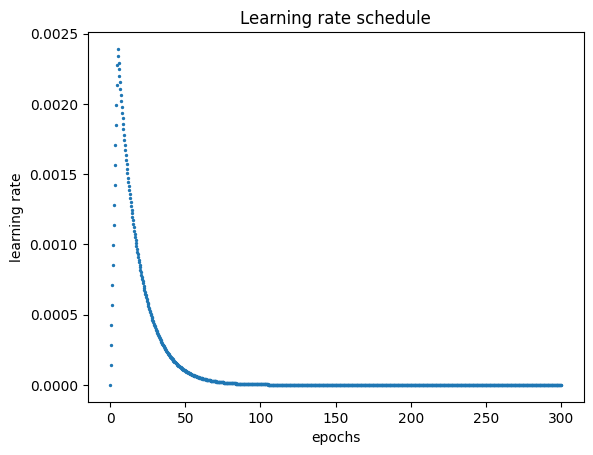

In [9]:
tf.keras.backend.clear_session()
gc.collect()
tf.config.optimizer.set_jit(True)

with strategy.scope():
# Define model
    inp1 = layers.Input((MAX_INPUT_LEN,6*NUM_POINTS))
    inp2 = layers.Input((MAX_OUTPUT_LEN-1,))
    x = CoordEmbedding()(inp1)
    y = TokenEmbedding()(inp2)
    for _ in range(num_enc_layers):
        x = EncoderTransformerBlock(head_size,num_heads,dropout, kernel_size)(x)
    for _ in range(num_dec_layers):
        y = DecoderTransformerBlock(head_size, num_heads, dropout)(x,y)
    logits = layers.Dense(VOCAB_SIZE)(y)
    try:
        del logits._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model((inp1,inp2),logits) 

    # Define learning rate and weight decay schedule
    schedule = OneCycleLR(lr, epochs, warmup_epochs=warmup_epochs, steps_per_epoch=steps_per_epoch,
                      resume_epoch=resume_epoch, decay_epochs=decay_epochs, lr_min=lr_min,
                      decay_type=decay_type, warmup_type='linear')
    decay_schedule = OneCycleLR(0.05*lr, epochs, warmup_epochs=warmup_epochs, 
                            steps_per_epoch=steps_per_epoch,
                            resume_epoch=resume_epoch, decay_epochs=decay_epochs, 
                            lr_min=0.05*lr_min, decay_type=decay_type, warmup_type='linear')
    # Define optimizers
    optimizer=tfa.optimizers.RectifiedAdam(learning_rate=schedule,weight_decay=decay_schedule,sma_threshold=4)
    optimizer=tfa.optimizers.Lookahead(optimizer,sync_period=5)
    #optimizer = tf.keras.optimizers.AdamW(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    


    model.compile(loss = masked_loss,
                 optimizer = optimizer,
                 metrics=[masked_accuracy],
                 steps_per_execution=steps_per_epoch
                 )
    
model.summary()
schedule.plot()

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='/kaggle/working/'+model_output_name+'.ckpt',
                save_weights_only=True,
                monitor='val_masked_accuracy', # Later change to val_norm_levenshtein
                mode='max',
                save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(
                monitor='val_masked_accuracy',
                patience=early_stop_patience,
                mode='max',
                start_from_epoch=0)
callbacks = [ckpt_callback, early_stop_callback]



Epoch 1/300
219/219 - 2322s - loss: 4.1545 - masked_accuracy: 0.0856 - val_loss: 2.7163 - val_masked_accuracy: 0.2009 - 2322s/epoch - 11s/step
Epoch 2/300
219/219 - 45s - loss: 2.8179 - masked_accuracy: 0.1867 - val_loss: 2.4558 - val_masked_accuracy: 0.2711 - 45s/epoch - 205ms/step
Epoch 3/300
219/219 - 45s - loss: 2.4235 - masked_accuracy: 0.2864 - val_loss: 2.0033 - val_masked_accuracy: 0.4207 - 45s/epoch - 206ms/step
Epoch 4/300
219/219 - 45s - loss: 1.9914 - masked_accuracy: 0.4176 - val_loss: 1.6533 - val_masked_accuracy: 0.5210 - 45s/epoch - 206ms/step
Epoch 5/300
219/219 - 45s - loss: 1.7310 - masked_accuracy: 0.4926 - val_loss: 1.4084 - val_masked_accuracy: 0.5896 - 45s/epoch - 205ms/step
Epoch 6/300
219/219 - 45s - loss: 1.5311 - masked_accuracy: 0.5514 - val_loss: 1.3163 - val_masked_accuracy: 0.6268 - 45s/epoch - 206ms/step
Epoch 7/300
219/219 - 45s - loss: 1.3646 - masked_accuracy: 0.5998 - val_loss: 1.1749 - val_masked_accuracy: 0.6631 - 45s/epoch - 205ms/step
Epoch 8/300

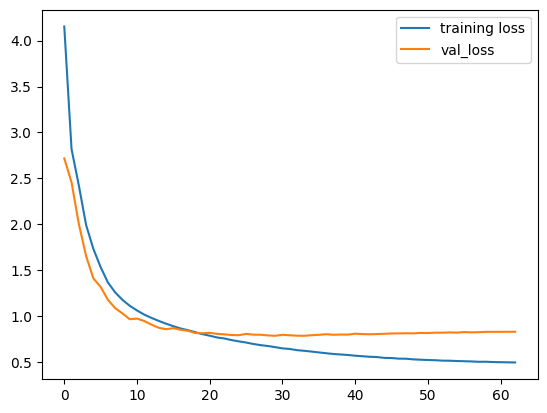

In [10]:
history = model.fit(train_ds, 
                    epochs = epochs-resume_epoch, 
                    callbacks = callbacks,
                    validation_data = val_ds,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps = val_steps,
                    verbose = verbose)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])
plt.show();

In [11]:
#for batch in train_ds.take(1):
#    out = model(batch[0], training=False)
    

In [12]:
#out = model(batch[0],training=False)

In [13]:
#masked_loss(batch[1],out)

In [14]:
#out